In [38]:
from numpy.random import uniform, normal
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
def sample(N: int, B: int, start_theta: tuple, sigma: float):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta = start_theta
    for b in range(B): #burnin samples
        results = step(theta, sigma)
        theta = results['theta']
    
    samples = []
    for n in range(N):
        results = step(theta, sigma)
        theta = results['theta']
        samples.append(results)
    return samples

def step(theta: tuple, sigma: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, sigma) #sample a new set of parameters
    acceptance_probability = calc_acceptance_prob(theta, theta_prime, sigma) #calculate the probability of acceptance
    accepted = acceptance_probability > uniform() #probabilistically determine acceptance 
    return {'accepted': accepted, 'acceptance_prob': acceptance_probability, 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, sigma: float):
    """Samples the two normal variables that comprise theta."""
    a,b = theta
    a = normal(a,sigma)
    b = normal(b,sigma)
    return (a,b)

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, sigma: float):
    """A Bayesian formulation..."""
    return 0.9

In [90]:
samples = sample(10000, 10000, (0,0), 1)

In [91]:
df = pd.DataFrame(samples)
df[['a','b']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
df = df.drop('theta',axis=1)

In [92]:
df

,accepted,acceptance_prob,a,b
0,True,0.9,-174.660374,-65.818583
1,True,0.9,-173.832371,-66.438564
2,True,0.9,-174.483532,-65.812543
3,True,0.9,-175.957835,-65.430651
4,True,0.9,-176.239664,-66.071717
...,...,...,...,...
9995,True,0.9,-96.012832,23.023193
9996,True,0.9,-95.680858,22.224117
9997,True,0.9,-97.031436,21.701966
9998,True,0.9,-97.061944,21.653711


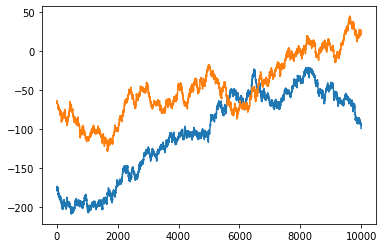

In [93]:
plt.plot(range(len(df)),df['a'])
plt.plot(range(len(df)),df['b'])

Great! Basic example of MH working. Now need to implement the Bayesian formulation. in calc_acceptance_prob().